In [1]:
## imports
import pandas as pd
import numpy as np
import os
import seaborn as sns
import re
import matplotlib.pyplot as plt

# Introduction

In this project, I will be participating in a kaggle competition to classify whether a twitter tweet is about a natural disaster or not. The link to the competition is provided below: https://www.kaggle.com/c/nlp-getting-started.

The data provided consists of a training and test set, where both tables have the following columns

    id - a unique identifier for each tweet
    text - the text of the tweet
    location - the location the tweet was sent from (may be blank)
    keyword - a particular keyword from the tweet (may be blank)
    target - in train.csv only, this denotes whether a tweet is about a real disaster (1) or not (0)

In [2]:
train = pd.read_csv(os.path.join('data','train.csv'))
test = pd.read_csv(os.path.join('data','test.csv'))

train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


# Exploratory Data Analysis

It's a good idea to get an understanding of the data that I will be working with in this project, so for this section I will be creating visuals to illustrate properties of my training data set. 



Text(0.5, 1.0, 'Test Data Keyword Number Null')

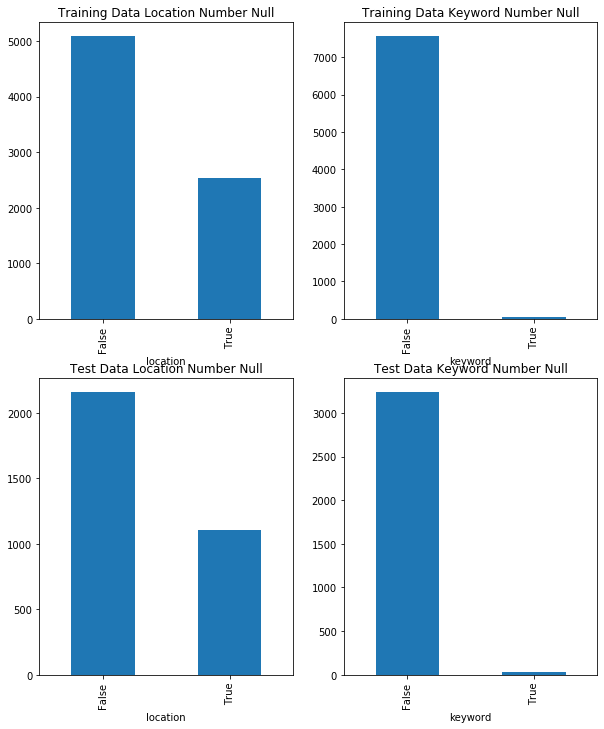

In [3]:
plt.subplots(2,2, figsize = (10,12))
## Training Set
plt.subplot(2,2,1)
train.groupby(train.location.isnull())['id'].count().plot(kind = 'bar')
plt.title('Training Data Location Number Null')
plt.subplot(2,2,2)
train.groupby(train.keyword.isnull())['id'].count().plot(kind = 'bar')
plt.title('Training Data Keyword Number Null')

## Test Set
plt.subplot(2,2,3)
test.groupby(test.location.isnull())['id'].count().plot(kind = 'bar')
plt.title('Test Data Location Number Null')
plt.subplot(2,2,4)
test.groupby(test.keyword.isnull())['id'].count().plot(kind = 'bar')
plt.title('Test Data Keyword Number Null')


This graph of number of nulls for training set and test set for location/keywords show me that they come from the same sample/distribution as the proportions of nulls for keyword/location is the same.

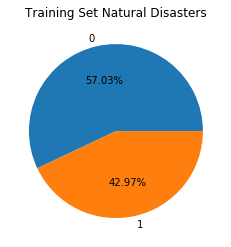

In [4]:
plt.pie(x = train['target'].value_counts(),labels= train['target'].value_counts().index,autopct='%1.2f%%')
plt.title('Training Set Natural Disasters')
plt.show()

This pie chart shows that about 43% of our tweets that we are trying to classify will actually be about natural disasters. We expect that the test set will have similar results if it is pulled from same sample.

In [5]:
## creating the two data sets so we can explore key words of both natural disasters and non natural disasters
natural_disasters = train [train['target'] == 1]
non_natural_disasters = train [train['target'] != 1]

Text(0.5, 1.0, 'Non_Natural Disasters Key words')

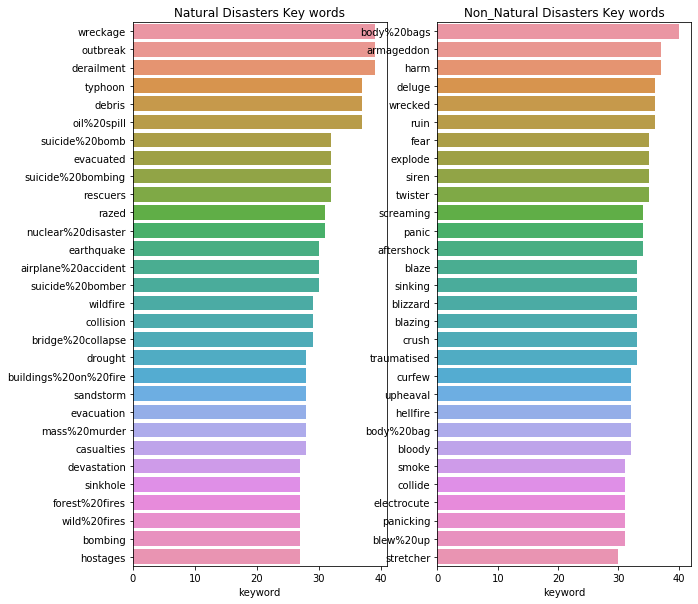

In [6]:
plt.subplots(1,2,figsize = (10,10))

## natural disasters key words tweets
plt.subplot(1,2,1)
sns.barplot(natural_disasters['keyword'].value_counts()[:30],
            natural_disasters['keyword'].value_counts().index[:30])
plt.title('Natural Disasters Key words')

## non_natural disasters_keywords
plt.subplot(1,2,2)
sns.barplot(non_natural_disasters['keyword'].value_counts()[:30],
            non_natural_disasters['keyword'].value_counts().index[:30])
plt.title('Non_Natural Disasters Key words')

Looking at the keywords, we observe that the most frequent words we observe in the natural disasters graph is  what we would expect, as words like outbreak/wreckage/typhoon are among the top. We also see words that we would expect in natural disasters such as fear, panic, explode in the non-natural disasters key words but that could be due to other incidents like murders/crimes which isn't technically a natural disaster.

Another signifigant thing I observed is the prescense of % which means that I probably need to clean do some cleaning and also suicide%bombing and suicide%bomber are different "tokens" so meaning I will need to clean

# Text Cleaning

In this section, I will be cleaning the text from both the training and test set.

### Removing punctuation, spaces, urls, digits

This subsection removes some noise from the text for instance, it removes additional spaces, urls, punctuation, and digits/measures of digits

In [7]:
import string

## helper function to remove some noise
def removing_noise(x):
    ## lower case
    x = x.lower()
    ## dealing with additional spaces
    x = re.sub('\s+',' ',x)
    ## removing urls
    x = re.sub('http\S+|www\S+|\w*\.com\S+', '',x)
    ## removing punctuation
    x = x.translate(str.maketrans('', '', string.punctuation))
    ## removing digits and measures of units
    x = re.sub('\w*\d\w*','',x)
    return x

## applying helper function
train['text'] = train['text'].apply(removing_noise)
test['text'] = test['text'].apply(removing_noise)

### Removing Stopwords

A stop word is a commonly used word (such as “the”, “a”, “an”, “in”) in the English Language. I am removing stopwords because it adds no significance to the text meaning that these words won't help us differentiate a non-disaster vs a disaster. This will save us a lot of time with proccessing 

In [8]:
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize 

##stopwords helper function
def remove_stopwords(x):
    stop_words = set(stopwords.words('english')) 
    word_tokens = word_tokenize(x) 
    filtered_sentence = [w for w in word_tokens if not w in stop_words] 
    return " ".join(filtered_sentence)

## using the helper function
train['text'] = train['text'].apply(remove_stopwords)
test['text'] = test['text'].apply(remove_stopwords)

In [9]:
train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,deeds reason earthquake may allah forgive us,1
1,4,NaN,NaN,forest fire near la ronge sask canada,1
2,5,NaN,NaN,residents asked shelter place notified officer...,1
3,6,NaN,NaN,people receive wildfires evacuation orders cal...,1
4,7,NaN,NaN,got sent photo ruby alaska smoke wildfires pou...,1


### Stemming

Now we will fix the problem we found during EDA( where words are not in their root word creating inconsistincies) by changing all the words to it's root word. We will do this by using a process called Stemming which turns all words to it's root word for example deeds in the first index will be made into deed.

In [10]:
from nltk.stem.porter import PorterStemmer

ps = PorterStemmer()

def stemSentence(x):
    text = [ps.stem(word) for word in x.split()]
    return ' '.join(text)

train['text'] = train['text'].apply(stemSentence)
test['text'] = test['text'].apply(stemSentence)

# Vectorization

In this section I will turn the tokens into vectors

## Bag of Words

Because I elimated stop words already, doing tfidf would be redundant because what tfidf does is make words that occur more often, have less meaning but since I eliminated stopwords, no need. Instead I will just create a bag of words( meaning I would vectorize the counts of each token per sentence)

In [11]:
from sklearn.feature_extraction.text import CountVectorizer

count_vectorizer = CountVectorizer(binary=True)
count_vectorizer.fit(train['text'])

## 1gram
train_x_1gram = count_vectorizer.transform(train['text'])
test_x_1gram = count_vectorizer.transform(test['text'])

Here I also created bigrams and trigrams of the Count Vectorizer in which I will also try to  feed to my model to see it it improves!

In [12]:
from sklearn.feature_extraction.text import CountVectorizer

count_vectorizer = CountVectorizer(binary=True, ngram_range=(2, 2))
count_vectorizer.fit(train['text'])

## bigrams
train_x_bigram = count_vectorizer.transform(train['text'])
test_x_bigram = count_vectorizer.transform(test['text'])


In [13]:
from sklearn.feature_extraction.text import CountVectorizer

count_vectorizer = CountVectorizer(binary=True, ngram_range=(3, 3))
count_vectorizer.fit(train['text'])

## tri grams
train_x_trigram = count_vectorizer.transform(train['text'])
test_x_trigram = count_vectorizer.transform(test['text'])


## Building the Model

Here I finally create the model after vectorizing my tokens

In [62]:
## creating target variable
y = train['target']

## making train test splits to score it
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(train_x_1gram, y)

Here I created a training and test set so that I can score my models and pick the best overall model

In [63]:
## importing the models
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import BernoulliNB

I'm gonna try 4 different models and get the score of each model. The 4 models are: LogisticRegression, Gaussian Naiive Bayes, Multionimal Naiive Bayes, and Bernoulli Naiive Bayes.

## Logistic Regression

In [96]:
model = LogisticRegression( solver = 'lbfgs')
model.fit(X_train,y_train)
model.score(X_test,y_test)

0.8046218487394958

In [88]:
def return_score():
    """ returns score of one trial """
    X_train, X_test, y_train, y_test = train_test_split(train_x_1gram, y)
    m = LogisticRegression( solver = 'lbfgs')
    m.fit(X_train, y_train)
    return m.score(X_test, y_test)

In [89]:
def return_average(n):
    """ returns average score """
    return np.array([return_score() for i in range(n)]).mean()

In [90]:
return_average(10)

0.7946953781512606

Let's try using bi and tri gram to see if its betters. As you can see it doesn't look like it makes the models better so I wont be trying it on the rest of the models

In [92]:
def return_score():
    """ returns score of one trial """
    X_train, X_test, y_train, y_test = train_test_split(train_x_bigram, y)
    m = LogisticRegression( solver = 'lbfgs')
    m.fit(X_train, y_train)
    return m.score(X_test, y_test)

In [93]:
return_average(10)

0.7394957983193278

In [ ]:
def return_score():
    """ returns score of one trial """
    X_train, X_test, y_train, y_test = train_test_split(train_x_trigram, y)
    m = LogisticRegression( solver = 'lbfgs')
    m.fit(X_train, y_train)
    return m.score(X_test, y_test)

In [94]:
return_average(10)

0.7344012605042016

## Gaussian Naiive Bayes

In [103]:
model = GaussianNB()
model.fit(X_train.toarray(),y_train)
model.score(X_test.toarray(),y_test)

0.6176470588235294

In [100]:
def return_score():
    """ returns score of one trial """
    X_train, X_test, y_train, y_test = train_test_split(train_x_1gram, y)
    model = GaussianNB()
    model.fit(X_train.toarray(),y_train)
    return model.score(X_test.toarray(),y_test)

In [101]:
return_average(10)

0.6039915966386554

This model seems a lot worse than a simple logistic regression

## Multinomial Naiive Bayes

In [106]:
model = MultinomialNB()
model.fit(X_train,y_train)
model.score(X_test,y_test)

0.8019957983193278

In [107]:
def return_score():
    """ returns score of one trial """
    X_train, X_test, y_train, y_test = train_test_split(train_x_1gram, y)
    model = MultinomialNB()
    model.fit(X_train.toarray(),y_train)
    return model.score(X_test.toarray(),y_test)

In [108]:
return_average(10)

0.7964285714285715

This model seems slightly better than the logistic regression model

## Bernoulli Naiive Bayes

In [110]:
model = BernoulliNB()
model.fit(X_train,y_train)
model.score(X_test,y_test)

0.8046218487394958

In [112]:
def return_score():
    """ returns score of one trial """
    X_train, X_test, y_train, y_test = train_test_split(train_x_1gram, y)
    model = MultinomialNB()
    model.fit(X_train.toarray(),y_train)
    return model.score(X_test.toarray(),y_test)

In [113]:
return_average(10)

0.7967962184873949

This model seems just as good as the Multinomial Naiive Bayes classifier so I will probably submit this one

## Submission File

In [118]:
model = BernoulliNB()
model.fit(train_x_1gram,y)

BernoulliNB(alpha=1.0, binarize=0.0, class_prior=None, fit_prior=True)

In [121]:
sample_submission = pd.read_csv(os.path.join('Data','sample_submission.csv'))
sample_submission['target'] = model.predict(test_x_1gram)
sample_submission.head()

,id,target
0,0,1
1,2,0
2,3,1
3,9,1
4,11,1


In [122]:
sample_submission.to_csv("submission.csv", index=False)